In [38]:
import os
import time
import glob
import pandas as pd
import numpy  as np
import tables as tb

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm     as colormap

# cities
from invisible_cities.cities.detsim      import detsim
from invisible_cities.cities.diomira     import diomira
from invisible_cities.cities.hypathia    import hypathia
from invisible_cities.cities.dorothea    import dorothea
from invisible_cities.cities.penthesilea import penthesilea
from invisible_cities.cities.esmeralda   import esmeralda
from invisible_cities.cities.beersheba   import beersheba
from invisible_cities.cities.isaura      import isaura

from invisible_cities.core.system_of_units import *

from invisible_cities.core.configure   import configure
from invisible_cities.core.configure   import all    as all_events

from invisible_cities.database import load_db

Loaded backend nbAgg version unknown.


In [39]:
plt.rcParams["font.size"]      = 15
plt.rcParams["font.family"]    = "sans-serif"
plt.rcParams["font.monospace"] = "Computer Modern Sans Serif"

In [40]:
inputfilename = os.path.expandvars("nexus_1_0nubb.h5")
config = pd.read_hdf(inputfilename, "MC/configuration").set_index("param_key")

# DetSim

**El-gain**: \
https://www.sciencedirect.com/science/article/pii/S0370269310000420 \
https://core.ac.uk/reader/82436370 \
\
**Diffusion**: \
https://arxiv.org/abs/1804.01680

$D'_{L, T} = \frac{D^*_{L, T}}{\sqrt{P}}$


**IMPORTANT**: Note that the physical parameters above must be the same used in the Kr production, since this notebook uses Kr map and Kr psfs.

In [41]:
E  = 17.5 * kV/cm
p  = 13.5 * bar
dx = 1    * cm
el_gain = dx*p*(170*(1/kV)*(E/p - 0.70*(kV/cm/bar)))

print("EL gain:", el_gain)

event = 14

EL gain: 1368.5000000000005


In [42]:
# configure
conf = configure('detsim $PWD/templates/detsimTemplate.conf'.split())

conf["files_in"]    = inputfilename
conf["file_out"]    = "/tmp/detsim.h5"
conf["event_range"] = (event, event+1)

conf["s1_lighttable"] = "$HOME/NEXT/DATA/LightTables/NEXT100_S1_LT.h5"
conf["s2_lighttable"] = "$HOME/NEXT/DATA/LightTables/NEXT100_S2_LT.h5"
conf["sipm_psf"]      = "$HOME/NEXT/DATA/LightTables/NEXT100_PSF.h5"

conf["print_mod"] = 1

dconf = conf

# run
t0 = time.time()
result = detsim(**conf)
print("Exec (s)", time.time()-t0)

events processed: 0, event number: 14
Exec (s) 15.555001974105835


In [43]:
eventMap = pd.read_hdf(conf["file_out"], "Run/eventMap")

In [45]:
event_idx = 0

event       = eventMap.loc[event_idx].evt_number
nexus_event = eventMap.loc[event_idx].nexus_evt

print("Event:", event)

with tb.open_file(conf["file_out"]) as h5file:
    pmtrd  = h5file.root.pmtrd [event_idx]
    sipmrd = h5file.root.sipmrd[event_idx]

Event: 28


<IPython.core.display.Javascript object>


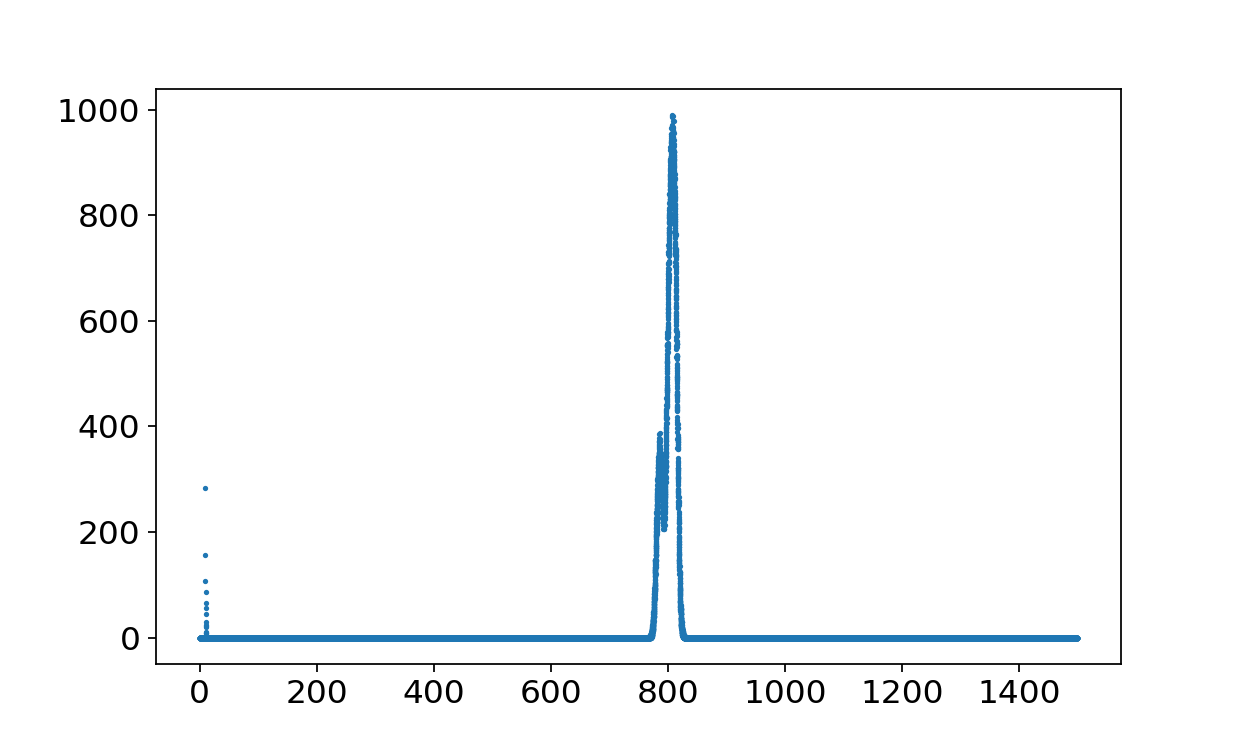

In [46]:
plt.figure(figsize=[5, 3])
times = np.arange(0, conf["buffer_params"]["length"], conf["buffer_params"]["pmt_width"])/mus
plt.scatter(times, pmtrd.sum(axis=0), s=2)

<IPython.core.display.Javascript object>


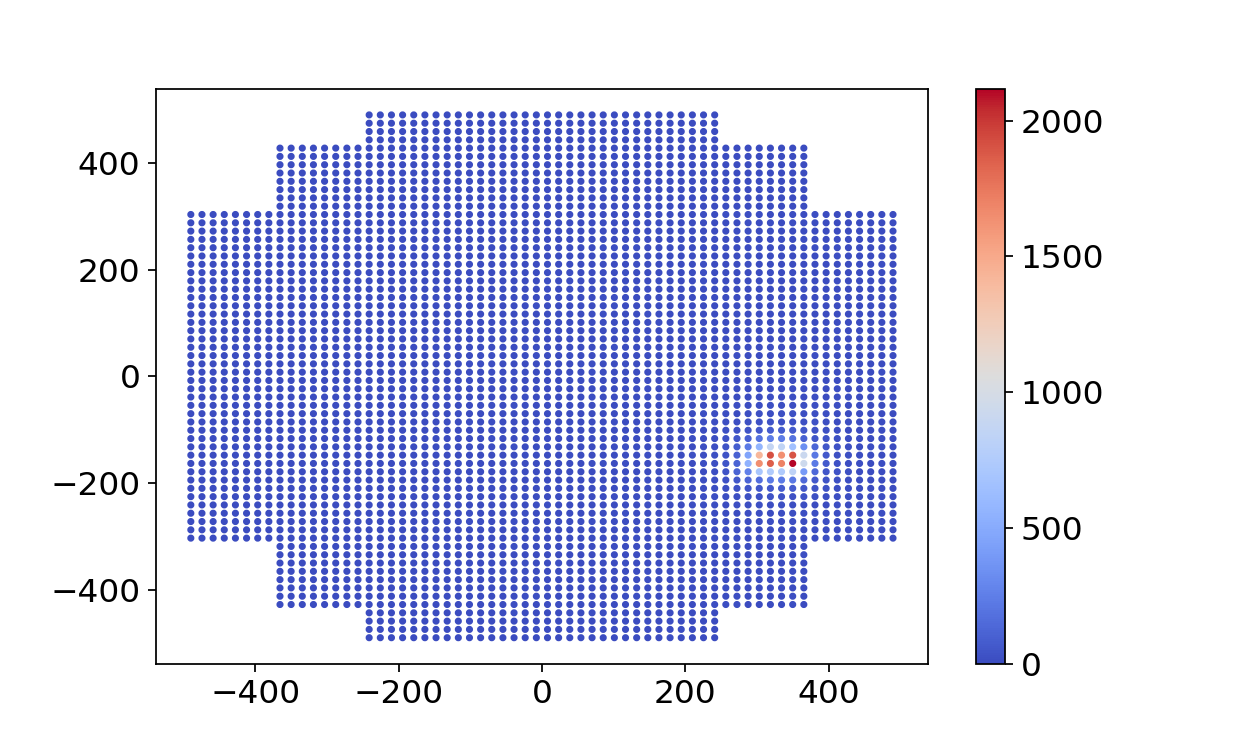

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fc223c6c040>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fc223c6c040> on colorbar
Setting pcolormesh


In [47]:
datasipm = load_db.DataSiPM(conf["detector_db"], conf["run_number"])

charge = np.sum(sipmrd, axis=1)
sel = charge >= 0
norm   = colors.Normalize(vmin=min(charge), vmax=max(charge), clip=True)
mapper = colormap.ScalarMappable(norm=norm, cmap=colormap.coolwarm)

plt.figure(figsize=[5, 3])
plt.scatter(datasipm["X"][sel], datasipm["Y"][sel], marker=".", s=20, color=mapper.to_rgba(charge[sel]))
plt.colorbar(mapper)

# Hypathia

In [48]:
# configure
conf = configure('hypathia $PWD/templates/hypathiaTemplate.conf'.split())

conf["files_in"]   = "/tmp/detsim.h5"
conf["file_out"]   = "/tmp/hypathia.h5"

hconf = conf

# run
t0 = time.time()
result = hypathia(**conf)
print("Exec (s)", time.time()-t0)

events processed: 0, event number: 28
Exec (s) 2.9744768142700195


In [49]:
S1   = pd.read_hdf(conf["file_out"], "PMAPS/S1")
S2   = pd.read_hdf(conf["file_out"], "PMAPS/S2")
S2Si = pd.read_hdf(conf["file_out"], "PMAPS/S2Si")

<IPython.core.display.Javascript object>


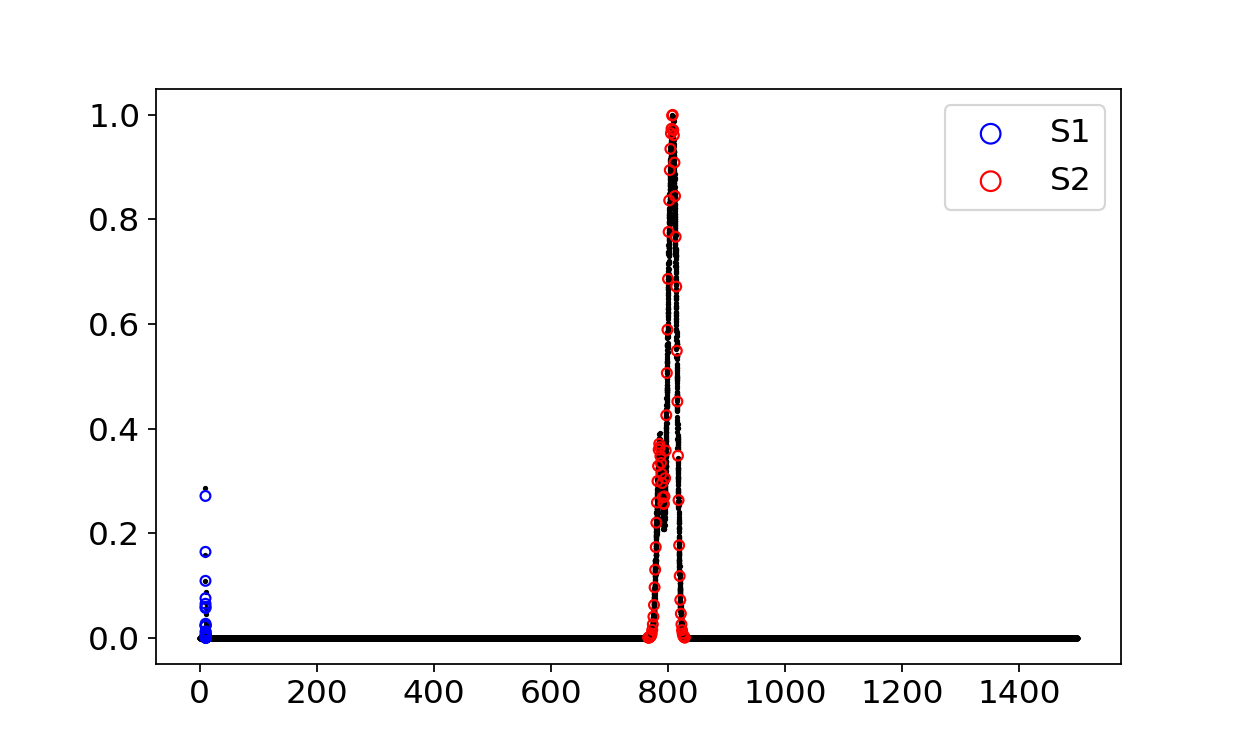

In [50]:
plt.figure(figsize=[5, 3])
times = np.arange(0, dconf["buffer_params"]["length"], dconf["buffer_params"]["pmt_width"])/mus
plt.scatter(times, pmtrd.sum(axis=0)/pmtrd.sum(axis=0).max(), s=2, color="k")

# S1
plt.scatter(S1["time"]/mus, S1["ene"]/pmtrd.sum(axis=0).max(), 
            s=20, facecolor="none", edgecolor="b", label="S1")

# S2
plt.scatter(S2["time"]/mus, S2["ene"]/S2["ene"].max(), 
            s=20, facecolor="none", edgecolor="r", label="S2")

plt.legend(markerscale=2)

<IPython.core.display.Javascript object>


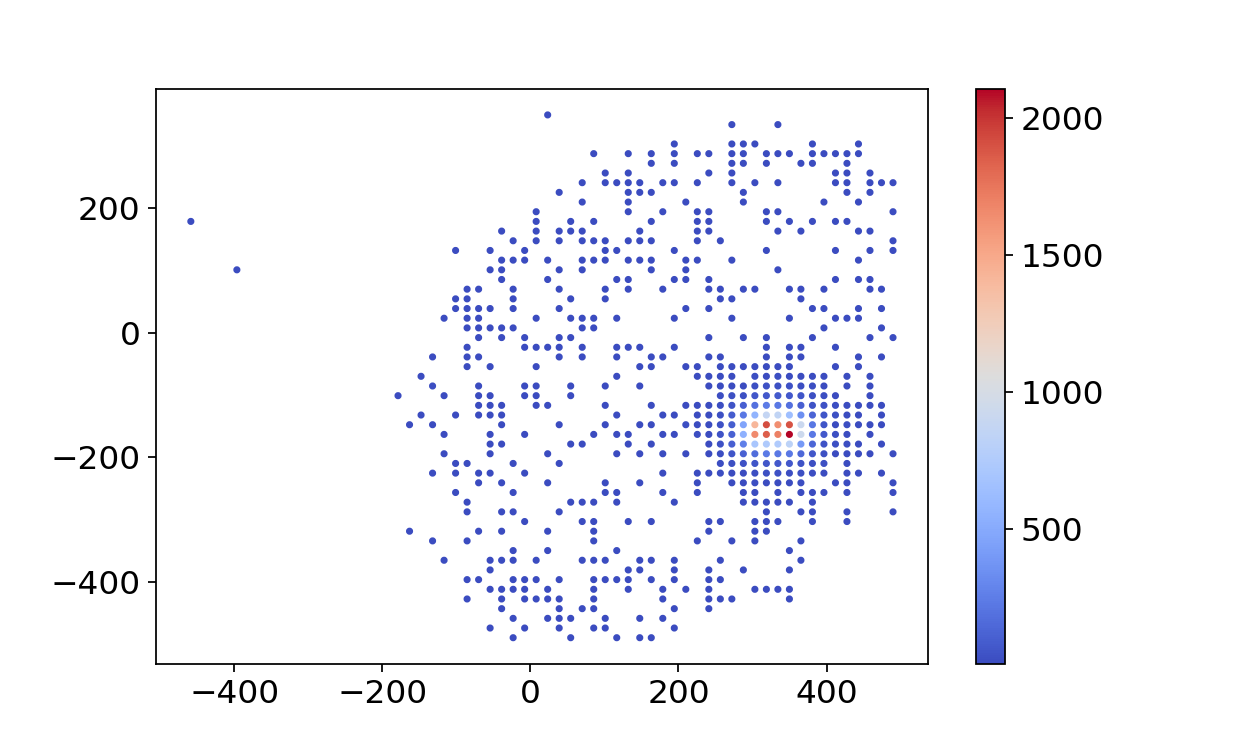

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fc226878700>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fc226878700> on colorbar
Setting pcolormesh


In [51]:
datasipm = load_db.DataSiPM(conf["detector_db"], conf["run_number"])

charge   = S2Si.groupby("nsipm").ene.sum().to_frame()
sel_sipm = datasipm.loc[charge.index]
norm   = colors.Normalize(vmin=min(charge["ene"]), vmax=max(charge["ene"]), clip=True)
mapper = colormap.ScalarMappable(norm=norm, cmap=colormap.coolwarm)

plt.figure(figsize=[5, 3])
plt.scatter(sel_sipm["X"], sel_sipm["Y"], marker=".", s=20, color=mapper.to_rgba(charge["ene"]))
plt.colorbar(mapper)

In [14]:
# print("S1 energy:", S1.ene.sum())
# print("S1 width :", S1.bwidth.sum())
# print()
# print("S2 energy:", S2.ene.sum())
# print("S2 width :", S2.bwidth.sum()/1000)

# Penthesilea

In [52]:
# configure
conf = configure('penthesilea $PWD/templates/penthesileaTemplate.conf'.split())

conf["files_in"]   = "/tmp/hypathia.h5"
conf["file_out"]   = "/tmp/penthesilea.h5"

# run
t0 = time.time()
result = penthesilea(**conf)
print("Exec (s)", time.time()-t0)

events processed: 0, event number: 28
Exec (s) 1.013249158859253


In [53]:
dst    = pd.read_hdf(conf["file_out"], "DST/Events")
reco   = pd.read_hdf(conf["file_out"], "RECO/Events")
mchits = pd.read_hdf(conf["file_out"], "MC/hits")

In [54]:
# plt.figure(figsize=[5, 3])
# plt.scatter(reco.X, reco.Y, marker=".", s=20, color=mapper.to_rgba(RECO["Q"]))
# plt.scatter( dst.X,  dst.Y, marker="*", facecolor="w", edgecolor="r", s=100, alpha=1)
# plt.colorbar(mapper)

<IPython.core.display.Javascript object>


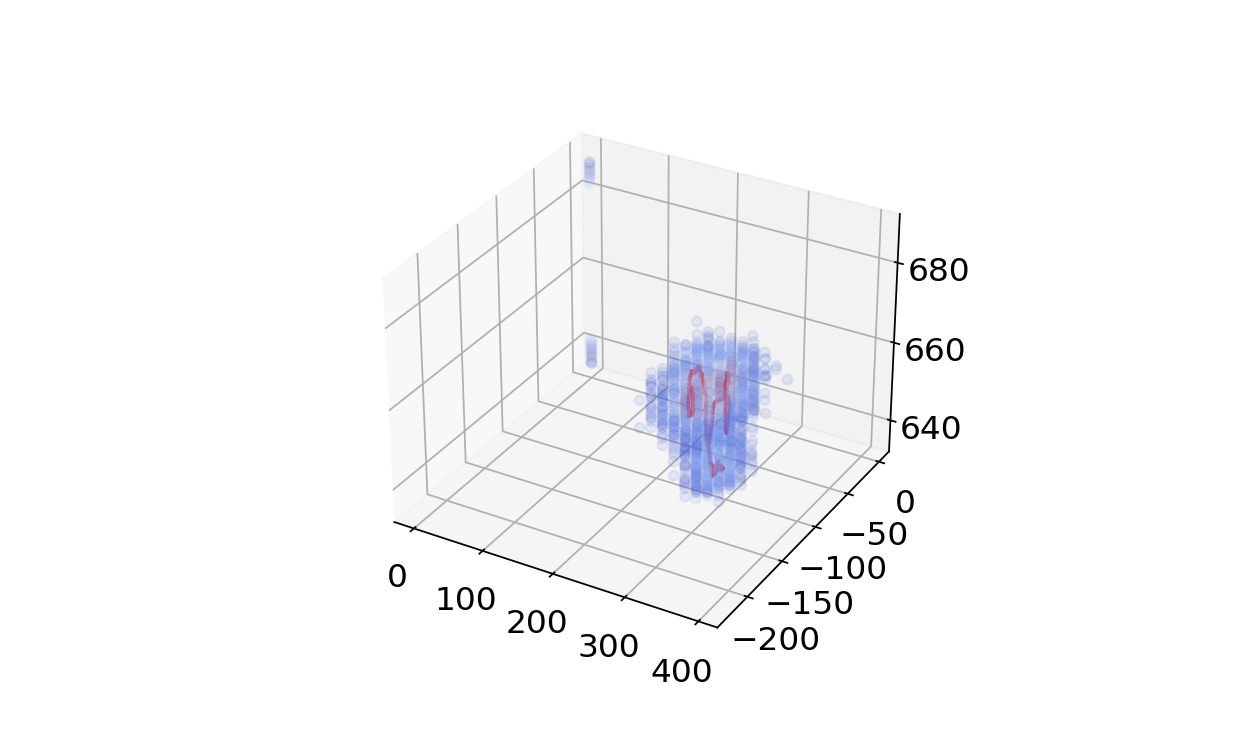

In [55]:
fig = plt.figure(figsize=[5, 3])
ax = fig.add_subplot(projection='3d')

# plot
norm   = colors.Normalize(vmin=0, vmax=reco.E.max(), clip=True)
mapper = colormap.ScalarMappable(norm=norm, cmap=colormap.coolwarm)

# chits
ax.scatter(reco.X, reco.Y, reco.Z, color=mapper.to_rgba(reco.E), alpha=0.1)

# mchits
ax.scatter(mchits["x"], mchits["y"], mchits["z"], c="r", s=1)

# Dorothea

In [19]:
# # configure
# conf = configure('dorothea $PWD/templates/dorotheaTemplate.conf'.split())

# conf["files_in"]   = "/tmp/hypathia.h5"
# conf["file_out"]   = "/tmp/dorothea.h5"
# conf["run_number"] = 0
# conf["event_range"]= all_events
# conf["print_mod"]  = 1

# # run
# t0 = time.time()
# result = dorothea(**conf)
# print("Exec (s)", time.time()-t0)

In [20]:
# dst = pd.read_hdf(conf["file_out"], "DST/Events")
# dst

# Esmeralda

In [56]:
# configure
conf = configure('esmeralda $PWD/templates/esmeraldaTemplate.conf'.split())

conf["files_in"]  = "/tmp/penthesilea.h5"
conf["file_out"]  = "/tmp/esmeralda.h5"

conf["cor_hits_params"]["map_fname"] = "$HOME/NEXT/DATA/LightTables/map_NEXT100_MC_r470.h5"

econf = conf

t0 = time.time()
result = esmeralda(**conf)
print("Exec (s)", time.time()-t0)

events processed: 0, event number: 28
Exec (s) 3.973050117492676


In [57]:
chits   = pd.read_hdf(econf["file_out"], "CHITS/lowTh")
tracks  = pd.read_hdf(econf["file_out"], "Tracking/Tracks")
summary = pd.read_hdf(econf["file_out"], "Summary/Events")
dst     = pd.read_hdf(econf["file_out"], "DST/Events")
mchits  = pd.read_hdf(econf["file_out"], "MC/hits")

# clear spureous tracks
tracks = tracks[tracks["length"]>0]

<IPython.core.display.Javascript object>


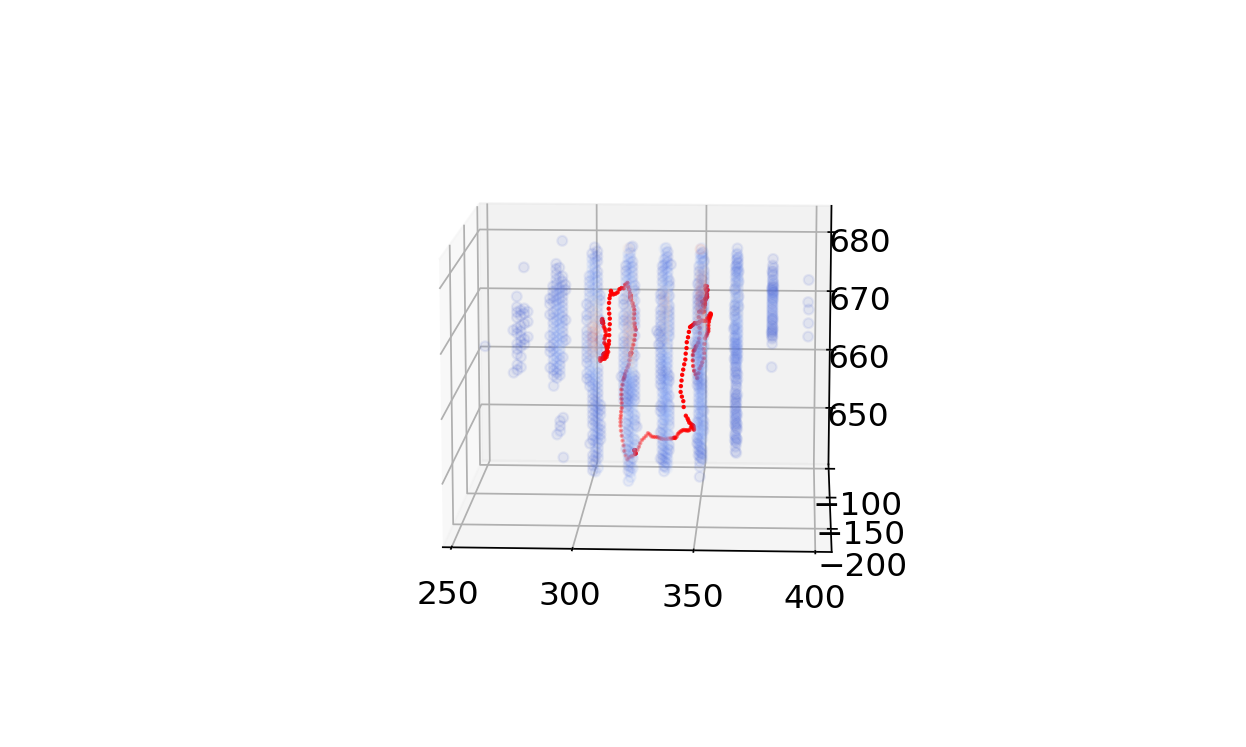

In [58]:
fig = plt.figure(figsize=[5, 3])
ax = fig.add_subplot(projection='3d')

# plot
norm   = colors.Normalize(vmin=0, vmax=chits.Ec.max(), clip=True)
mapper = colormap.ScalarMappable(norm=norm, cmap=colormap.coolwarm)

# chits
ax.scatter(chits.X, chits.Y, chits.Z, color=mapper.to_rgba(chits.Ec), alpha=0.1)

# mchits
ax.scatter(mchits["x"], mchits["y"], mchits["z"], c="r", s=1)

In [59]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# for track_id, track in tracks.groupby("trackID"):
#     hits = chits[chits["track_id"]==track_id]
    
#     # plot
#     norm   = colors.Normalize(vmin=0, vmax=hits.Ec.max(), clip=True)
#     mapper = colormap.ScalarMappable(norm=norm, cmap=colormap.coolwarm)

#     # chits
#     ax.scatter(hits.X, hits.Y, hits.Z, color=mapper.to_rgba(hits.Ec), alpha=0.5)

#     # mchits
#     ax.scatter(mchits["x"], mchits["y"], mchits["z"], c="r", s=1)

#     # blobs
#     ax.scatter(track["blob1_x"], track["blob1_y"], track["blob1_z"], marker="*", s=200, c="k")
#     ax.scatter(track["blob2_x"], track["blob2_y"], track["blob2_z"], marker="*", s=200, c="k")

In [60]:
# from invisible_cities.io.hits_io       import hits_from_df
# from invisible_cities.cities.esmeralda import track_blob_info_creator_extractor

# paolina_algorithm = track_blob_info_creator_extractor(**conf["paolina_params"])

# hitc = hits_from_df(chits)[chits["event"].unique()[0]]
# df, track_hitc, out_of_map = paolina_algorithm(hitc)

# Beersheba

In [67]:
# configure
conf = configure('beersheba $PWD/templates/beershebaTemplate.conf'.split())

conf["files_in"]  = "/tmp/esmeralda.h5"
conf["file_out"]  = "/tmp/beersheba.h5"

conf["deconv_params"]["psf_fname"] = "$HOME/NEXT/DATA/LightTables/NEXT100_PSF_kr83m.h5"

bconf = conf

t0 = time.time()
result = beersheba(**conf)
print("Exec (s)", time.time()-t0)

events processed: 0, event number: 28
Exec (s) 31.573059797286987


In [68]:
deco = pd.read_hdf(bconf["file_out"], "DECO/Events")

## Isaura

In [69]:
# configure
conf = configure('isaura $PWD/templates/isauraTemplate.conf'.split())

conf["files_in"]  = "/tmp/beersheba.h5"
conf["file_out"]  = "/tmp/isaura.h5"

iconf = conf

t0 = time.time()
result = isaura(**conf)
print("Exec (s)", time.time()-t0)

events processed: 0, event number: 28
Exec (s) 5.359283924102783


In [70]:
summary  = pd.read_hdf(conf["file_out"], "Summary/Events")
tracking = pd.read_hdf(conf["file_out"], "Tracking/Tracks")
mchits   = pd.read_hdf(econf["file_out"], "MC/hits")

<IPython.core.display.Javascript object>


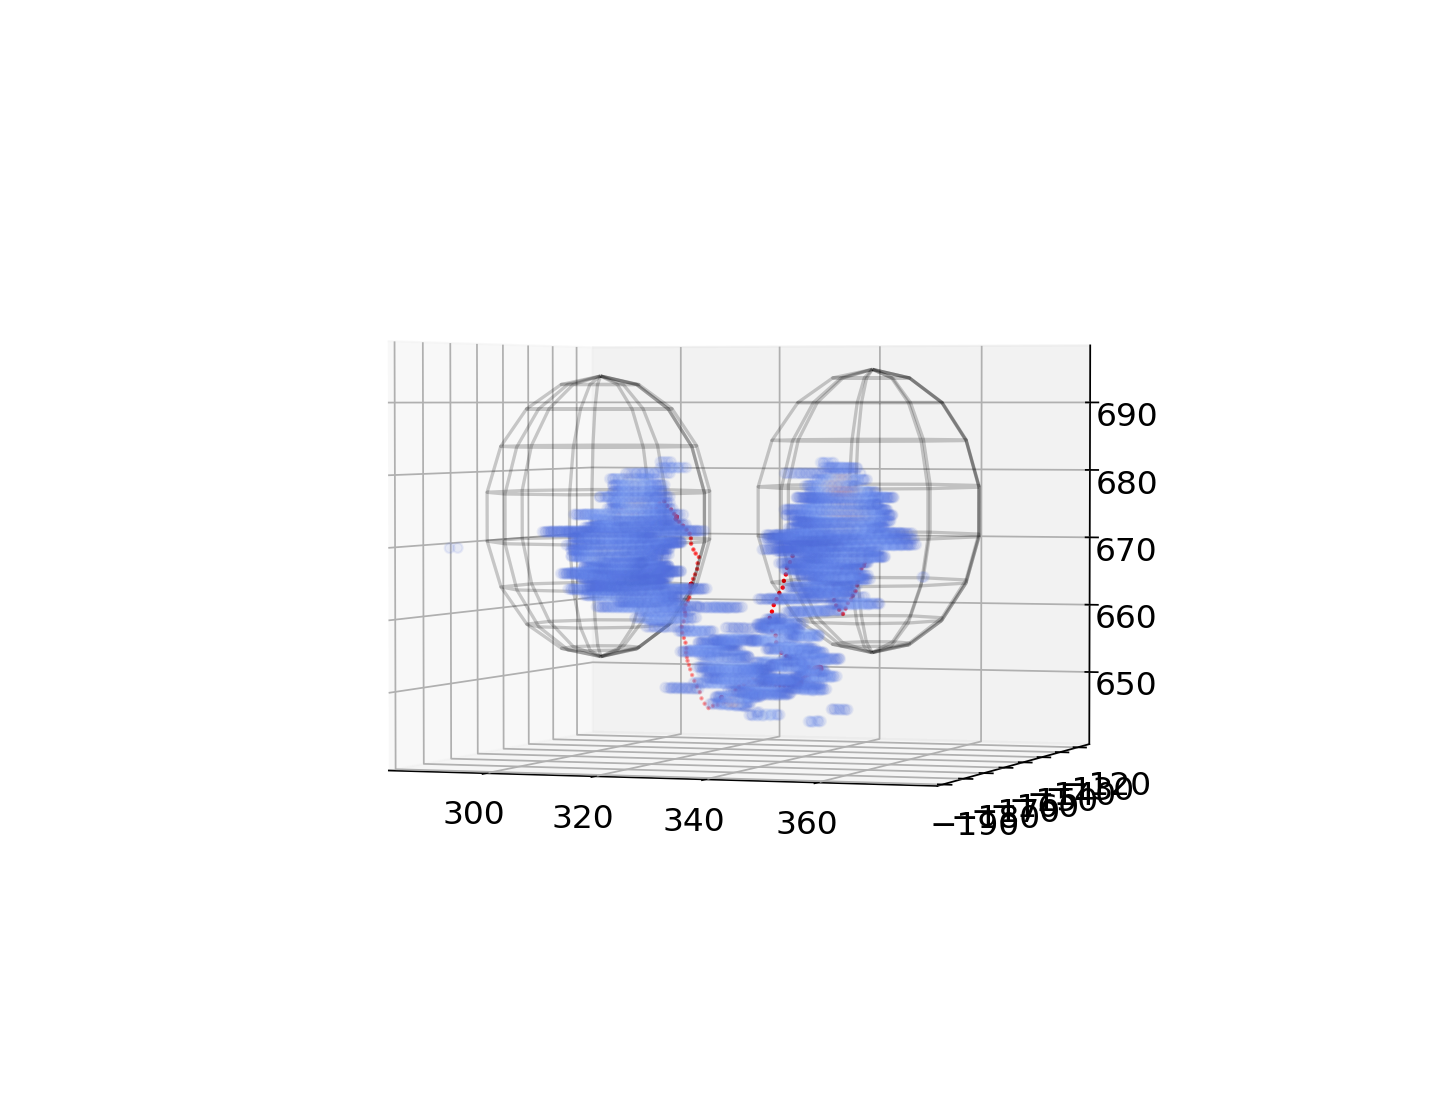

In [71]:
fig = plt.figure(figsize=[5, 3])
ax = fig.add_subplot(projection='3d')

norm   = colors  .Normalize(vmin=0, vmax=deco.E.max(), clip=True)
mapper = colormap.ScalarMappable(norm=norm, cmap=colormap.coolwarm)

ax.scatter(deco.X, deco.Y, deco.Z, color=mapper.to_rgba(deco.E), alpha=0.1)

# mchits
ax.scatter(mchits["x"], mchits["y"], mchits["z"], c="r", s=1)


# blobs
r = iconf["paolina_params"]["blob_radius"]
phi, theta = np.mgrid[0:2*np.pi:10j, 0:np.pi:10j]
x = r*np.sin(theta)*np.cos(phi)
y = r*np.sin(theta)*np.sin(phi)
z = r*np.cos(theta)

# select track with maximum energy
t = tracking.loc[tracking["energy"].idxmax()]
b1_x, b1_y, b1_z = t.blob1_x, t.blob1_y, t.blob1_z
b2_x, b2_y, b2_z = t.blob2_x, t.blob2_y, t.blob2_z

ax.plot_wireframe(x+b1_x, y+b1_y, z+b1_z, alpha=0.2, color="k")
ax.plot_wireframe(x+b2_x, y+b2_y, z+b2_z, alpha=0.2, color="k")

In [72]:
summary

,event,evt_energy,evt_charge,evt_ntrks,evt_nhits,evt_x_avg,evt_y_avg,evt_z_avg,evt_r_avg,evt_x_min,evt_y_min,evt_z_min,evt_r_min,evt_x_max,evt_y_max,evt_z_max,evt_r_max,evt_out_of_map
0,28,2.390233,-1.0,2,9542,329.494886,-156.690736,666.98256,364.995972,290.675,-187.325,643.036642,337.111645,361.675,-118.325,681.60918,393.696788,False


# Paolina

In [31]:
# from invisible_cities.types.ic_types import xy
# from invisible_cities.evm            import event_model       as evm
# from invisible_cities.reco           import paolina_functions as plf

# from invisible_cities.cities.esmeralda import types_dict_tracks

# def track_blob_info_creator_extractor(vox_size         : [float, float, float],
#                                       strict_vox_size  : bool                 ,
#                                       energy_threshold : float                ,
#                                       min_voxels       : int                  ,
#                                       blob_radius      : float                ,
#                                       max_num_hits     : int):
#     def create_extract_track_blob_info(hitc):
#         df = pd.DataFrame(columns=list(types_dict_tracks.keys()))
#         if len(hitc.hits) > max_num_hits:
#             return df, hitc, True
#         #track_hits is a new Hitcollection object that contains hits belonging to tracks, and hits that couldnt be corrected
#         track_hitc = evm.HitCollection(hitc.event, hitc.time)
#         out_of_map = np.any(np.isnan([h.Ep for h in hitc.hits]))
#         if out_of_map:
#             #add nan hits to track_hits, the track_id will be -1
#             track_hitc.hits.extend  ([h for h in hitc.hits if np.isnan   (h.Ep)])
#             hits_without_nan       = [h for h in hitc.hits if np.isfinite(h.Ep)]
#             #create new Hitcollection object but keep the name hitc
#             hitc      = evm.HitCollection(hitc.event, hitc.time)
#             hitc.hits = hits_without_nan

#         if len(hitc.hits) > 0:
#             voxels           = plf.voxelize_hits(hitc.hits, vox_size, strict_vox_size, evm.HitEnergy.Ep)
#             (    mod_voxels,
#              dropped_voxels) = plf.drop_end_point_voxels(voxels, energy_threshold, min_voxels)
#             tracks           = plf.make_track_graphs(mod_voxels)

#             for v in dropped_voxels:
#                 track_hitc.hits.extend(v.hits)

#             vox_size_x = voxels[0].size[0]
#             vox_size_y = voxels[0].size[1]
#             vox_size_z = voxels[0].size[2]
#             del(voxels)
#             #sort tracks in energy
#             tracks     = sorted(tracks, key=plf.get_track_energy, reverse=True)

#             track_hits = []
#             for c, t in enumerate(tracks, 0):
#                 tID = c
#                 energy = plf.get_track_energy(t)
#                 length = plf.length(t)
#                 numb_of_hits   = len([h for vox in t.nodes() for h in vox.hits])
#                 numb_of_voxels = len(t.nodes())
#                 numb_of_tracks = len(tracks   )
#                 pos   = [h.pos for v in t.nodes() for h in v.hits]
#                 x, y, z = map(np.array, zip(*pos))
#                 r = np.sqrt(x**2 + y**2)

#                 e     = [h.Ep for v in t.nodes() for h in v.hits]
#                 ave_pos = np.average(pos, weights=e, axis=0)
#                 ave_r   = np.average(r  , weights=e, axis=0)
#                 extr1, extr2 = plf.find_extrema(t)
#                 extr1_pos = extr1.XYZ
#                 extr2_pos = extr2.XYZ

#                 blob_pos1, blob_pos2 = plf.blob_centres(t, blob_radius)

#                 e_blob1, e_blob2, hits_blob1, hits_blob2 = plf.blob_energies_and_hits(t, blob_radius)
#                 overlap = float(sum(h.Ep for h in set(hits_blob1).intersection(set(hits_blob2))))
#                 list_of_vars = [hitc.event, tID, energy, length, numb_of_voxels,
#                                 numb_of_hits, numb_of_tracks,
#                                 min(x), min(y), min(z), min(r), max(x), max(y), max(z), max(r),
#                                 *ave_pos, ave_r, *extr1_pos,
#                                 *extr2_pos, *blob_pos1, *blob_pos2,
#                                 e_blob1, e_blob2, overlap,
#                                 vox_size_x, vox_size_y, vox_size_z]

#                 df.loc[c] = list_of_vars

#                 for vox in t.nodes():
#                     for hit in vox.hits:
#                         hit.track_id = tID
#                         track_hits.append(hit)

#             #change dtype of columns to match type of variables
#             df = df.apply(lambda x : x.astype(types_dict_tracks[x.name]))
#             track_hitc.hits.extend(track_hits)
#         return df, mod_voxels, track_hitc, out_of_map

#     return create_extract_track_blob_info

In [32]:
# from invisible_cities.io.hits_io       import hits_from_df

# paolina_params = dict( vox_size         = [10 * mm, 10 * mm, 10 * mm]
#                      , strict_vox_size  = False
#                      , energy_threshold = 100 * keV
#                      , min_voxels       = 3
#                      , blob_radius      = 21 * mm
#                      , max_num_hits     = 30000)

# paolina_algorithm = track_blob_info_creator_extractor(**paolina_params)

# # deco hits
# DECO = DECO.reindex(columns=CHITS.columns)
# DECO["time"] = 0
# DECO["Ec"]   = DECO["E"]
# DECO["Ep"]   = DECO["E"]
# hitc = hits_from_df(DECO)[DECO["event"].unique()[0]]

# df, voxels, track_hitc, out_of_map = paolina_algorithm(hitc)

In [33]:
# # select track ids with length>0
# df = df[df["length"]>0]
# track_ids = df.trackID.values

# voxels = [voxel for voxel in voxels if voxel.hits[0].track_id in track_ids]

In [34]:
# voxel_pos  = np.array([voxel.pos for voxel in voxels])
# voxel_ene  = np.array([voxel.E   for voxel in voxels])

# lower_corners = np.array([voxel.pos-voxel.size/2. for voxel in voxels])
# upper_corners = np.array([voxel.pos+voxel.size/2. for voxel in voxels])
# corners = np.concatenate((lower_corners, upper_corners))
# corners = np.unique(corners, axis=0)
# x, y, z = np.unique(corners[:, 0]), np.unique(corners[:, 1]), np.unique(corners[:, 2])

# filled, _ = np.histogramdd(voxel_pos, bins=[x, y, z])
# filled  = np.swapaxes(filled, 0, 1).astype(bool)
# x, y, z = np.meshgrid(x, y, z)

In [35]:
# fig = plt.figure()
# ax = fig.gca(projection='3d')

# norm   = colors  .Normalize(vmin=min(voxel_ene), vmax=max(voxel_ene), clip=True)
# mapper = colormap.ScalarMappable(norm=norm, cmap=colormap.coolwarm)

# ax.voxels(x, y, z, filled, alpha=0.5, facecolor=mapper.to_rgba(voxel_ene))

# # mchits
# ax.scatter(mchits["x"], mchits["y"], mchits["z"], c="r", s=1)

# # blobs
# r = paolina_params["blob_radius"]
# phi, theta = np.mgrid[0:2*np.pi:10j, 0:np.pi:10j]
# x = r*np.sin(theta)*np.cos(phi)
# y = r*np.sin(theta)*np.sin(phi)
# z = r*np.cos(theta)

# # select track with maximum energy
# t = df.loc[df["energy"].idxmax()]
# b1_x, b1_y, b1_z = t.blob1_x, t.blob1_y, t.blob1_z
# b2_x, b2_y, b2_z = t.blob2_x, t.blob2_y, t.blob2_z

# ax.plot_wireframe(x+b1_x, y+b1_y, z+b1_z, alpha=0.2, color="k")
# ax.plot_wireframe(x+b2_x, y+b2_y, z+b2_z, alpha=0.2, color="k")